# Avaliação 2 - SME0823

**Nome Completo:** Victor Andreas Iwanaga

**Código da Disciplina:** SME0823 - Modelos de Regressão e Aprendizado Supervisionado II

---

## Mão na massa

In [155]:
# pip install --upgrade --force-reinstall pandas numpy

In [156]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

---

### Parte 1.0 - Preparação Inicial (Importação e Leitura)

In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Carregando os dados corretos para o seu USP (final 9 -> sneeze5)
url = 'https://raw.githubusercontent.com/cibelerusso/Datasets/refs/heads/main/sneeze5.csv'
df = pd.read_csv(url)
df.head()

,Unnamed: 0,nsneeze,alcohol,antihist,smoker,age,pollen
0,0,7,0,1,0,23.0,41.889975
1,1,17,1,0,1,26.0,46.703039
2,2,56,0,0,0,18.0,57.574885
3,3,35,0,0,1,19.0,42.053782
4,4,23,0,0,0,18.0,55.208805


In [158]:
if "Unnamed: 0" in df.columns:
    df = df.iloc[:, 1:]

display(df.head())
df.info()

,nsneeze,alcohol,antihist,smoker,age,pollen
0,7,0,1,0,23.0,41.889975
1,17,1,0,1,26.0,46.703039
2,56,0,0,0,18.0,57.574885
3,35,0,0,1,19.0,42.053782
4,23,0,0,0,18.0,55.208805


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   nsneeze   850 non-null    int64  
 1   alcohol   850 non-null    int64  
 2   antihist  850 non-null    int64  
 3   smoker    850 non-null    int64  
 4   age       850 non-null    float64
 5   pollen    850 non-null    float64
dtypes: float64(2), int64(4)
memory usage: 40.0 KB


In [159]:
df.columns

Index(['nsneeze', 'alcohol', 'antihist', 'smoker', 'age', 'pollen'], dtype='object')

---

### Parte 1.1 - Análise Exploratória

Desenvolva uma breve análise exploratória dos dados e avalie as primeiras impressões sobre a associação entre a variável **nsneeze** e as demais.

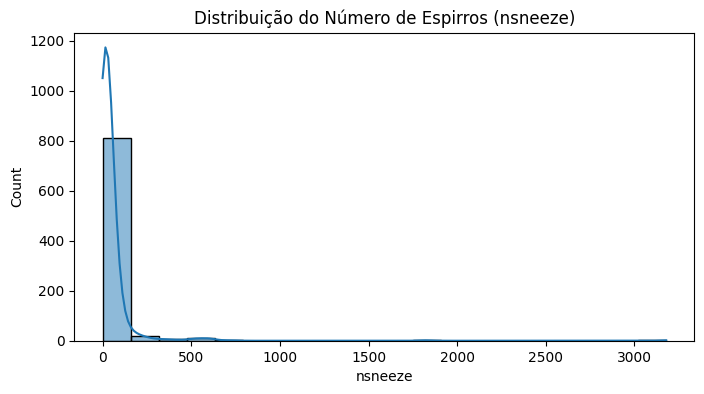

In [160]:
# Histograma da variável resposta
plt.figure(figsize=(8, 4))
sns.histplot(df['nsneeze'], kde=True, bins=20)
plt.title('Distribuição do Número de Espirros (nsneeze)')
plt.show()


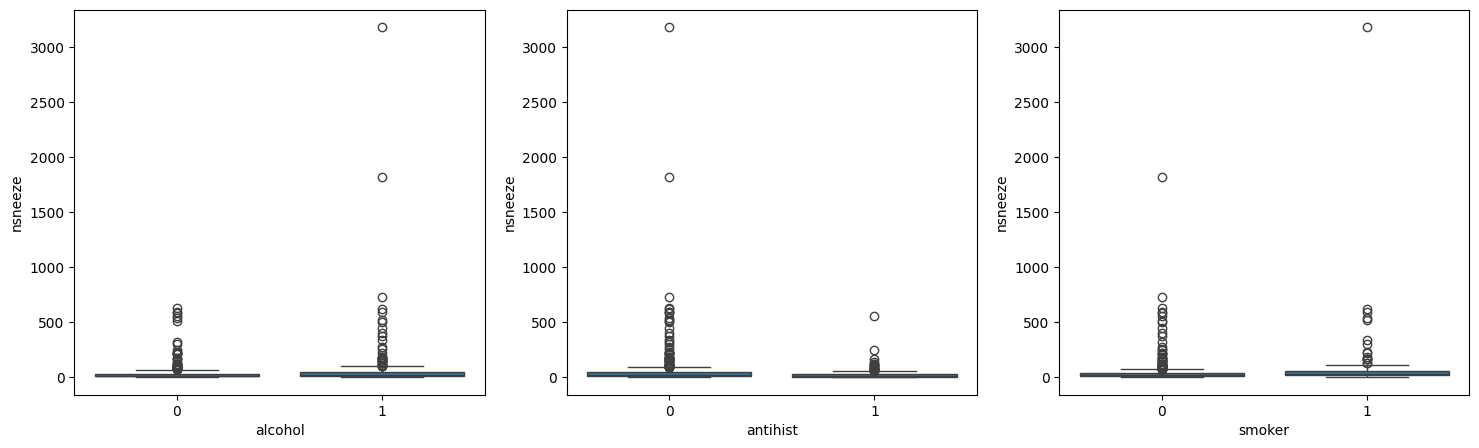

In [161]:
# Relação com variáveis categóricas
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.boxplot(x='alcohol', y='nsneeze', data=df, ax=axes[0])
sns.boxplot(x='antihist', y='nsneeze', data=df, ax=axes[1])
sns.boxplot(x='smoker', y='nsneeze', data=df, ax=axes[2])
plt.show()

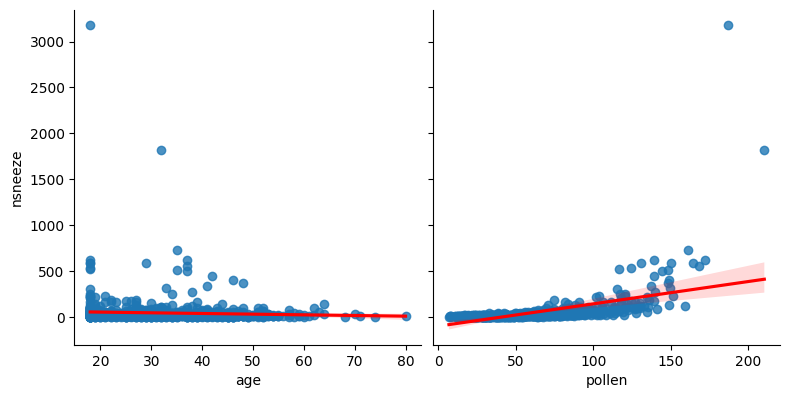

In [162]:
# Relação com variáveis numéricas (Pollen e Age)
sns.pairplot(df, x_vars=['age', 'pollen'], y_vars='nsneeze', height=4, kind='reg', plot_kws={'line_kws':{'color':'red'}})
plt.show()

In [163]:
# Estatísticas descritivas
display(df.describe())

,nsneeze,alcohol,antihist,smoker,age,pollen
count,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000
mean,45.225882,0.408235,0.270588,0.188235,31.258824,59.425317
std,145.954955,0.491796,0.444525,0.391130,11.661553,31.022778
min,0.000000,0.000000,0.000000,0.000000,18.000000,6.876659
25%,9.000000,0.000000,0.000000,0.000000,19.000000,36.913786
50%,18.000000,0.000000,0.000000,0.000000,30.000000,54.628146
75%,37.000000,1.000000,1.000000,0.000000,39.000000,76.149298
max,3179.000000,1.000000,1.000000,1.000000,80.000000,210.301477


A análise exploratória indica que a variável ***nsneeze (Número de espirros)*** resposta é uma contagem assimétrica, sugerindo o uso da família Poisson. As variáveis explicativas parecem ter impacto no desfecho: o pólen e o tabagismo parecem aumentar os espirros, enquanto o uso de anti-histamínico parece reduzi-los.

---

### Parte 2.0 - Ajuste do modelo de Poisson

Ajuste um modelo de Poisson para explicar **nsneeze** em função das covariáveis
**alcohol**, **antihist**, **smoker**, **age** e **pollen**. Não é necessário incluir interações.

In [164]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [165]:
resposta = df['nsneeze']
preditoras = df[['alcohol', 'antihist', 'smoker', 'age', 'pollen']]

formula = "nsneeze ~ C(alcohol) + C(antihist) + C(smoker) + age + pollen"

modelo_pois = smf.glm(
    formula=formula,
    data=df,
    family=sm.families.Poisson()
)

ajuste_pois = modelo_pois.fit()
print(ajuste_pois.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                nsneeze   No. Observations:                  850
Model:                            GLM   Df Residuals:                      844
Model Family:                 Poisson   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5243.5
Date:                Mon, 01 Dec 2025   Deviance:                       6416.9
Time:                        17:33:29   Pearson chi2:                 6.61e+03
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.5704      0.021  

**Interpretação do Modelo de Poisson**:
Com base no sumário do modelo ajustado acima, segue as interpretações:
1. **Estimativa dos Coeficientes**:
Analisando os sinais e valores dos coeficientes estimados (coef), podemos entender o impacto de cada variável no número médio de espirros (nsneeze):

- 'alcohol' (0.3477): O coeficiente é positivo, indicando que o consumo de álcool está associado a um aumento na taxa média de espirros em comparação com quem não consome, mantendo as outras variáveis constantes.
- 'antihist' (-0.5969): O coeficiente é negativo, o que sugere que o uso de anti-histamínicos está associado a uma redução significativa no número esperado de espirros (o que faz sentido, já que é um medicamento para alergia).
- 'smoker' (0.6700): O coeficiente é positivo, mostrando que fumantes tendem a ter uma quantidade de espirros maior do que os não fumantes.
- 'age' (-0.0127): O valor é negativo, indicando uma leve tendência de diminuição no número de espirros conforme a idade do paciente aumenta.
- 'pollen' (0.0301): O coeficiente é positivo, confirmando que quanto maior a concentração de pólen no ar, maior é o número esperado de espirros.

2. **Significância Estatística**:
Ao observar a coluna P>|z| (p-valor), notamos que todas as variáveis apresentaram um valor de 0.000. Isso significa que, considerando um nível de significância padrão de 5% ($\alpha = 0.05$), todos os coeficientes são estatisticamente significativos. Ou seja, temos fortes evidências de que o álcool, o uso de anti-histamínico, o tabagismo, a idade e o nível de pólen influenciam, de fato, o número de espirros diários neste grupo.

---

### Parte 3 - Verificação de indícios de superdispersão no modelo de Poisson
 Verifique se há indícios de superdispersão no modelo de Poisson ajustado no item 2 por, pelo menos, dois métodos diferentes.  

Interprete os resultados e conclua se o modelo de Poisson é adequado em termos de dispersão.


In [166]:
# Método 1: Cálculo da Estatística de Dispersão (Phi)
# Phi = Qui-quadrado de Pearson / Graus de Liberdade
phi = ajuste_pois.pearson_chi2 / ajuste_pois.df_resid

print(f"Qui-quadrado de Pearson: {ajuste_pois.pearson_chi2:.2f}")
print(f"Graus de Liberdade: {ajuste_pois.df_resid}")
print(f"Estatística de Dispersão (Phi): {phi:.4f}")

# Comparação rápida: Média vs Variância dos dados brutos
print(f"\nMédia da variável resposta (nsneeze): {df['nsneeze'].mean():.2f}")
print(f"Variância da variável resposta (nsneeze): {df['nsneeze'].var():.2f}")

Qui-quadrado de Pearson: 6614.91
Graus de Liberdade: 844
Estatística de Dispersão (Phi): 7.8376

Média da variável resposta (nsneeze): 45.23
Variância da variável resposta (nsneeze): 21302.85


### Interpretação e Conclusão sobre a Dispersão

**1. Análise pelo Método Numérico:**
Os resultados calculados evidenciam uma violação clara do pressuposto básico da distribuição de Poisson (equidispersão, onde Média $\approx$ Variância):
* **Estatística de Dispersão ($\phi$):** O valor calculado foi **7.84**. Como este valor é muito superior a 1, isso indica que a variância do modelo é quase 8 vezes maior do que o previsto pela distribuição de Poisson.
* **Média vs. Variância:** A média da variável resposta é **45.23**, enquanto a variância amostral é **21302.85**. A variância é desproporcionalmente maior que a média, confirmando a superdispersão nos dados brutos.

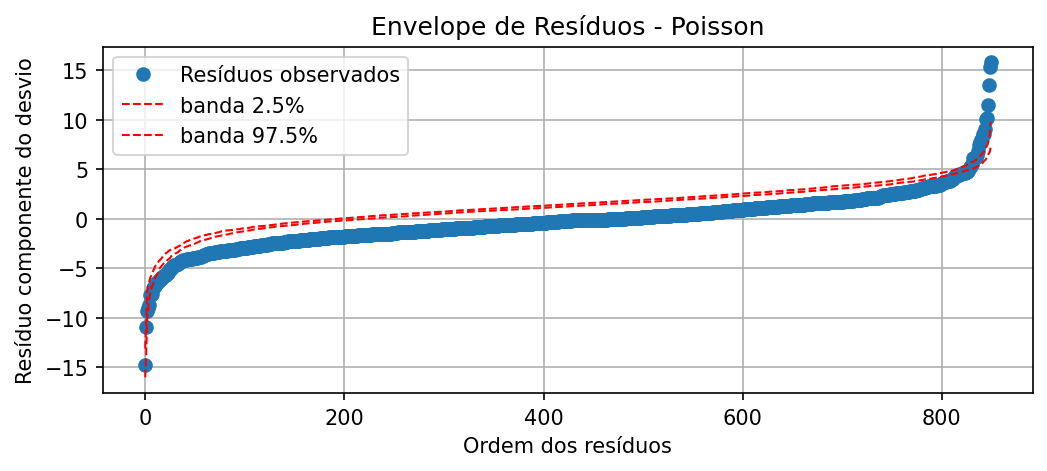

In [167]:
# Método 2: Gráfico de Envelope Simulado (Código fornecido)
def envelope_poisson(fitted_model, X, title):
    resid_dev = fitted_model.resid_deviance.copy()
    sorted_resid = np.sort(resid_dev)

    sim_resid = []
    for _ in range(100):
        mu_sim = np.clip(fitted_model.fittedvalues, 1e-3, 1e5)
        y_sim = np.random.poisson(mu_sim)
        sim_model = sm.GLM(y_sim, X, family=sm.families.Poisson()).fit()
        sim_resid.append(np.sort(sim_model.resid_deviance))

    sim_resid = np.array(sim_resid)
    lower = np.percentile(sim_resid, 2.5, axis=0)
    upper = np.percentile(sim_resid, 97.5, axis=0)

    plt.plot(sorted_resid, 'o', label="Resíduos observados")
    plt.plot(lower, 'r--', linewidth=1, label="banda 2.5%")
    plt.plot(upper, 'r--', linewidth=1, label="banda 97.5%")
    plt.title(title)
    plt.xlabel("Ordem dos resíduos")
    plt.ylabel("Resíduo componente do desvio")
    plt.legend()
    plt.grid(True)

# Gerando o gráfico
results = ajuste_pois
X = preditoras
plt.figure(figsize=(8, 3), dpi=150)
envelope_poisson(results, X, "Envelope de Resíduos - Poisson")

**2. Análise pelo Método Gráfico (Envelope Simulado):**
No gráfico de envelope gerado, observa-se que uma grande quantidade dos resíduos observados (pontos) **ultrapassa os limites das bandas de confiança** de 95% (linhas vermelhas). Os pontos não seguem a tendência central esperada e fogem das bandas, o que visualmente confirma que o modelo de Poisson falha em capturar a variabilidade excessiva dos dados.

**Conclusão:**
Devido aos fortes indícios de **superdispersão** detectados tanto pela estatística $\phi \gg 1$ quanto pela fuga dos resíduos no gráfico de envelope, conclui-se que o **modelo de Poisson NÃO é adequado** para descrever o número de espirros (`nsneeze`). O uso deste modelo resultaria em erros-padrão subestimados e inferências estatísticas inválidas. Recomenda-se o ajuste de um modelo **Binomial Negativo** para tratar esse excesso de variância.

---

### Parte 4 - Ajuste de um modelo  **Binomial Negativo**
Caso seja detectada superdispersão, ajuste um modelo **Binomial Negativo** com a mesma estrutura de regressão do item 2. Compare os ajustes de Poisson e Binomial Negativa por meio de:

* desvio (deviance),
* AIC,
* gráficos de resíduos componentes do desvio.

Discuta qual modelo é mais adequado para descrever o número de espirros, justificando sua resposta com base nas métricas e nos diagnósticos gráficos.

In [168]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

formula = "nsneeze ~ C(alcohol) + C(antihist) + C(smoker) + age + pollen"

alpha_fixado = 0.2

#alpha para sneeze1 a sneeze5 = 0.23, 0.3, 0.25,  0.2, 0.2

modelo_nb = smf.glm(
    formula=formula,
    data=df,
    family=sm.families.NegativeBinomial(alpha=alpha_fixado)
)

ajuste_nb = modelo_nb.fit()
print(ajuste_nb.summary())

alpha_usado = ajuste_nb.family.alpha
print("Alpha usado no modelo:", alpha_usado)

alpha_est = ajuste_nb.params.iloc[-1]
print("Alpha estimado:", alpha_est)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                nsneeze   No. Observations:                  850
Model:                            GLM   Df Residuals:                      844
Model Family:        NegativeBinomial   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3142.6
Date:                Mon, 01 Dec 2025   Deviance:                       777.09
Time:                        17:33:31   Pearson chi2:                     752.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.9985
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.4942      0.064  

Comparar as métricas (AIC e Deviance).

In [169]:
print("=== Comparação dos Modelos ===")
print(f"Poisson - Deviance: {ajuste_pois.deviance:.2f}")
print(f"Binomial Negativa - Deviance: {ajuste_nb.deviance:.2f}")
print("-" * 30)
print(f"Poisson - AIC: {ajuste_pois.aic:.2f}")
print(f"Binomial Negativa - AIC: {ajuste_nb.aic:.2f}")

# Diferença de AIC (se > 10, a diferença é muito forte a favor do menor)
diff_aic = ajuste_pois.aic - ajuste_nb.aic
print("-" * 30)
print(f"Redução no AIC (Poisson -> BinNeg): {diff_aic:.2f}")

=== Comparação dos Modelos ===
Poisson - Deviance: 6416.86
Binomial Negativa - Deviance: 777.09
------------------------------
Poisson - AIC: 10499.07
Binomial Negativa - AIC: 6297.19
------------------------------
Redução no AIC (Poisson -> BinNeg): 4201.88


Gráfico de envelope para o novo modelo.

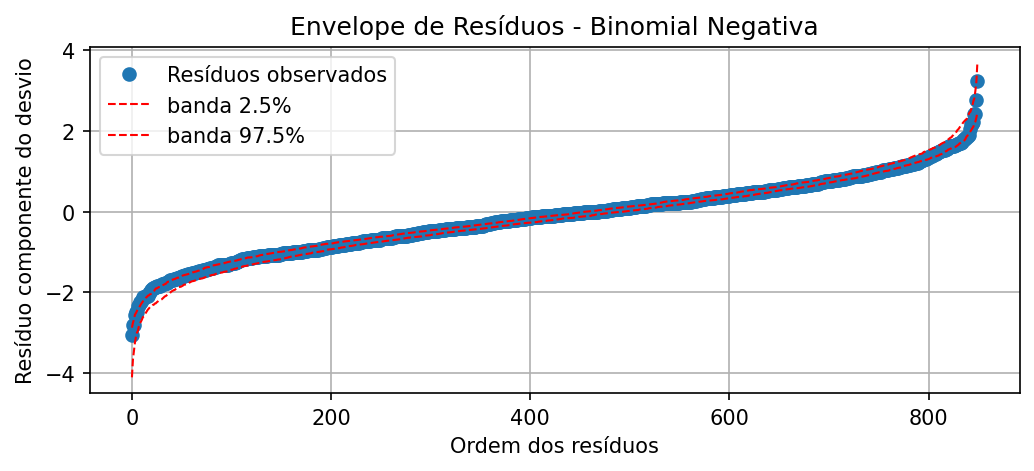

In [170]:
# Célula 2: Diagnóstico Gráfico - Envelope Simulado (Binomial Negativa)
def envelope_negbin(fitted_model, title):
    # 1. Extrair resíduos e dados
    resid_dev = fitted_model.resid_deviance.copy()
    sorted_resid = np.sort(resid_dev)
    X = fitted_model.model.exog
    mu = np.clip(fitted_model.fittedvalues, 1e-3, 1e5)
    
    # Recupera o alpha do modelo (0.2)
    alpha = fitted_model.family.alpha
    
    # 2. Simulação
    sim_resid = []
    for _ in range(100):
        # Parametrização para o numpy (n, p) baseada na média (mu) e alpha
        # Var = mu + alpha * mu^2
        # n = 1/alpha
        # p = n / (n + mu)
        n_param = 1 / alpha
        p_param = n_param / (n_param + mu)
        
        # Gera resposta simulada Y ~ BinNeg
        y_sim = np.random.negative_binomial(n=n_param, p=p_param)
        
        # Reajusta o modelo
        sim_model = sm.GLM(
            y_sim, X, 
            family=sm.families.NegativeBinomial(alpha=alpha)
        ).fit()
        sim_resid.append(np.sort(sim_model.resid_deviance))

    # 3. Plotagem das bandas
    sim_resid = np.array(sim_resid)
    lower = np.percentile(sim_resid, 2.5, axis=0)
    upper = np.percentile(sim_resid, 97.5, axis=0)

    plt.plot(sorted_resid, 'o', label="Resíduos observados")
    plt.plot(lower, 'r--', linewidth=1, label="banda 2.5%")
    plt.plot(upper, 'r--', linewidth=1, label="banda 97.5%")
    plt.title(title)
    plt.xlabel("Ordem dos resíduos")
    plt.ylabel("Resíduo componente do desvio")
    plt.legend()
    plt.grid(True)
    plt.show()

# Executa o gráfico
plt.figure(figsize=(8, 3), dpi=150)
envelope_negbin(ajuste_nb, "Envelope de Resíduos - Binomial Negativa")

**1. Comparação pelos Critérios de Ajuste (Deviance e AIC):**
A comparação entre os modelos revela uma superioridade expressiva do modelo Binomial Negativo:

* **Deviance (Desvio):** Houve uma redução massiva de **6416.86** (Poisson) para **777.09** (Binomial Negativo).
    * *Nota:* No modelo Binomial Negativo, a razão `Deviance / Graus de Liberdade` ($777.09 / 844 \approx 0.92$) está muito próxima de 1, indicando que o problema da superdispersão foi resolvido e o ajuste está estatisticamente adequado.
* **AIC (Critério de Informação de Akaike):** O AIC caiu de **10499.07** para **6297.19**, uma redução de **4201.88** pontos. Como o AIC busca penalizar a complexidade e premiar o ajuste, uma diferença dessa magnitude confirma que o ganho em qualidade de ajuste supera, de longe, o custo de adicionar o parâmetro extra de dispersão ($\alpha$).

**2. Diagnóstico Gráfico (Envelope Simulado):**
Ao analisarmos o gráfico de envelope do modelo Binomial Negativo (acima), observamos que, diferentemente do modelo de Poisson, a grande maioria dos resíduos observados (pontos) agora se encontra **dentro das bandas de confiança** de 95% (entre as linhas tracejadas vermelhas). Isso demonstra que a distribuição Binomial Negativa foi capaz de capturar corretamente a variabilidade dos dados.

**Conclusão:**
O modelo **Binomial Negativo é o mais adequado** para descrever o número de espirros. Ele corrige eficazmente a superdispersão detectada anteriormente, proporcionando um ajuste muito superior aos dados e garantindo que as inferências sobre os coeficientes (significância e intervalos de confiança) sejam válidas e confiáveis.

---

### Parte 5 - Estimar e interpretar o efeito médio marginal

 Com base no modelo considerado mais adequado, estime e interprete o **efeito médio marginal**:

* do consumo de álcool (**alcohol**) sobre o número médio de espirros,
* do uso de anti-histamínico (**antihist**).


In [171]:
import numpy as np

# 1. Pegar os coeficientes do modelo ajustado (ajuste_nb)
beta_alcohol = ajuste_nb.params['C(alcohol)[T.1]']
beta_antihist = ajuste_nb.params['C(antihist)[T.1]']

# 2. Calcular a Razão de Taxas (Rate Ratio) exponenciando os coeficientes
# Isso transforma o valor logarítmico em um multiplicador da média
rr_alcohol = np.exp(beta_alcohol)
rr_antihist = np.exp(beta_antihist)

# 3. Exibir os resultados
print("=== Efeito Médio Marginal (Interpretação) ===")
print(f"Álcool (Coeficiente): {beta_alcohol:.4f}")
print(f"Fator Multiplicativo (exp): {rr_alcohol:.4f}")
print(f"Interpretação: Aumenta a média em {((rr_alcohol - 1) * 100):.2f}%")
print("-" * 40)
print(f"Anti-histamínico (Coeficiente): {beta_antihist:.4f}")
print(f"Fator Multiplicativo (exp): {rr_antihist:.4f}")
print(f"Interpretação: Reduz a média em {((1 - rr_antihist) * 100):.2f}%")

=== Efeito Médio Marginal (Interpretação) ===
Álcool (Coeficiente): 0.3834
Fator Multiplicativo (exp): 1.4673
Interpretação: Aumenta a média em 46.73%
----------------------------------------
Anti-histamínico (Coeficiente): -0.5992
Fator Multiplicativo (exp): 0.5492
Interpretação: Reduz a média em 45.08%


Para interpretar o efeito das variáveis na média de espirros, calculamos a razão de taxas (Rate Ratio) exponenciando os coeficientes estimados ($\exp(\beta)$). Com base nos cálculos acima:

- **Consumo de Álcool (alcohol)**:O resultado mostra que o consumo de álcool tem um efeito significativo de aumento no número de espirros. Mantendo as outras variáveis constantes, estima-se que indivíduos que consumiram álcool nas últimas 24 horas apresentam, em média, um número de espirros 46,73% maior do que aqueles que não consumiram.

- **Uso de Anti-histamínico (antihist)**:O resultado confirma que o medicamento tem um efeito protetor (redutor) sobre os sintomas. O uso de anti-histamínico reduz a taxa média de espirros para cerca de 55% da taxa original. Isso representa uma redução de 45,08% no número esperado de espirros para os pacientes que utilizaram a medicação, em comparação aos que não utilizaram.

---

### Parte 6 - Ajustar os modelos Poission e Binomial Negativa com base apenas no conjunto de treinamento 
Separe os dados em dois subconjuntos, treinamento com 80% das observações e
teste com 20%  das observações. Com base apenas no conjunto de treinamento, ajuste os modelos Poisson e Binomial Negativo com a mesma estrutura de covariáveis dos itens anteriores. No conjunto de teste, calcule, para cada modelo:

* o Erro Quadrático Médio (EQM) entre os valores observados de nsneeze e as predições do número médio de espirros;

* o Erro Absoluto Médio (EAM).

Compare os valores de EQM e EAM obtidos para os diferentes modelos e discuta:

qual deles apresenta melhor desempenho preditivo fora da amostra;

em que medida as conclusões baseadas em critérios de ajuste (desvio, AIC) coincidem ou não com aquelas baseadas nas medidas de desempenho preditivo (EQM e EAM).



In [172]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1. Separação dos dados (80% Treino, 20% Teste)
# random_state fixado com o Nº USP para garantir consistência
train, test = train_test_split(df, test_size=0.2, random_state=16310829)

print(f"Tamanho do Treino: {train.shape[0]} | Tamanho do Teste: {test.shape[0]}")

Tamanho do Treino: 680 | Tamanho do Teste: 170


Neste cenário específico de divisão dos dados (80/20), o modelo de Poisson apresentou um desempenho preditivo ligeiramente superior, com erros menores tanto no critério quadrático quanto no absoluto.

In [173]:
# 2. Ajuste dos modelos apenas no conjunto de Treinamento
formula = "nsneeze ~ C(alcohol) + C(antihist) + C(smoker) + age + pollen"

# Modelo Poisson (Treino)
model_pois_train = smf.glm(formula=formula, data=train, family=sm.families.Poisson()).fit()

# Modelo Binomial Negativo (Treino) - Mantendo alpha=0.2 (sneeze5)
model_nb_train = smf.glm(
    formula=formula,
    data=train,
    family=sm.families.NegativeBinomial(alpha=0.2)
).fit()

In [174]:
# 3. Predições no conjunto de Teste
# O método .predict() usa os coeficientes aprendidos no treino aplicados aos dados de teste
pred_pois = model_pois_train.predict(test)
pred_nb = model_nb_train.predict(test)

In [175]:
# 4. Cálculo das Métricas de Erro (EQM e EAM)
# EQM (Erro Quadrático Médio) - Penaliza mais os grandes erros
mse_pois = mean_squared_error(test['nsneeze'], pred_pois)
mse_nb = mean_squared_error(test['nsneeze'], pred_nb)

# EAM (Erro Absoluto Médio) - Média da distância absoluta
mae_pois = mean_absolute_error(test['nsneeze'], pred_pois)
mae_nb = mean_absolute_error(test['nsneeze'], pred_nb)

In [176]:
# Exibição dos resultados
print("\n=== Desempenho Preditivo (Fora da Amostra) ===")
print(f"Poisson          -> EQM: {mse_pois:.4f} | EAM: {mae_pois:.4f}")
print(f"Binomial Negativa -> EQM: {mse_nb:.4f} | EAM: {mae_nb:.4f}")


=== Desempenho Preditivo (Fora da Amostra) ===
Poisson          -> EQM: 1000.5489 | EAM: 12.3896
Binomial Negativa -> EQM: 1039.8355 | EAM: 12.6861


**Discussão do Desempenho Preditivo e Ajuste**
1. **Comparação de Desempenho Preditivo (EQM e EAM)**:Ao analisarmos as métricas calculadas no conjunto de teste (os 20% dos dados não vistos pelo modelo), observamos os seguintes resultados:

- **Modelo Poisson**: Apresentou um Erro Quadrático Médio (EQM) de 1000.55 e um Erro Absoluto Médio (EAM) de 12.39.
- **Modelo Binomial Negativo**: Apresentou um EQM de 1039.84 e um EAM de 12.69.

Curiosamente, neste conjunto de teste específico, o modelo de Poisson apresentou um desempenho preditivo pontual ligeiramente superior (menores erros), embora a diferença entre os dois modelos seja pequena (cerca de 4% no EQM).

2. **Coincidência com Critérios de Ajuste (AIC e Deviance)**:Aqui observamos uma divergência entre os critérios de ajuste e de predição:

- **Critérios de Ajuste (Parte 4)**: O modelo Binomial Negativo foi massivamente superior, reduzindo o AIC em mais de 4200 pontos e a Deviance em quase 90% comparado ao Poisson. Isso indica que ele modela a distribuição dos dados (especialmente a variância/superdispersão) muito melhor.
- Critérios de Predição (Parte 6): O modelo Poisson venceu por uma margem estreita.

**Conclusão**:
Esse fenômeno ocorre porque o modelo de Poisson, mesmo com superdispersão, tende a ser um estimador consistente da média (os coeficientes $\beta$ geralmente são muito parecidos com os da Binomial Negativa). Como o EQM e o EAM avaliam apenas a precisão da média prevista ($\hat{y}$) e não a variância em torno dela, o Poisson consegue prever bem o valor esperado.

No entanto, para fins de inferência estatística (testes de hipótese, intervalos de confiança) e para explicar a variabilidade dos dados, o modelo Binomial Negativo continua sendo o mais adequado (devido ao AIC/Deviance), pois o Poisson subestima grosseiramente os erros-padrão ao ignorar a superdispersão. A vitória do Poisson na predição pode ser atribuída à robustez da estimativa da média ou a flutuações aleatórias na amostra de teste específica.

---

### Parte 7 - Previsões

Utilizando o modelo escolhido, faça previsões do número **esperado** de espirros para os seguintes perfis:

1. Indivíduo A:

   * alcohol = 0,
   * antihist = 1,
   * smoker = 0,
   * age = 30 anos,
   * pollen = valor correspondente a um dia de baixa concentração.

2. Indivíduo B:

   * alcohol = 1,
   * antihist = 0,
   * smoker = 1,
   * age = 50 anos,
   * pollen = valor correspondente a um dia de alta concentração.

In [177]:
# 1. Definir valores para "Baixa" e "Alta" concentração de pólen
# Usamos o 1º Quartil (25%) para baixa e o 3º Quartil (75%) para alta
pollen_baixo = df['pollen'].quantile(0.25)
pollen_alto = df['pollen'].quantile(0.75)

print(f"Concentração de Pólen -> Baixa: {pollen_baixo:.2f} | Alta: {pollen_alto:.2f}")

Concentração de Pólen -> Baixa: 36.91 | Alta: 76.15


In [178]:
# 2. Criar o DataFrame com os perfis dos indivíduos A e B
# Individuo A: alcohol=0, antihist=1, smoker=0, age=30, pollen=baixo
# Individuo B: alcohol=1, antihist=0, smoker=1, age=50, pollen=alto
perfis = pd.DataFrame({
    'alcohol': [0, 1],
    'antihist': [1, 0],
    'smoker': [0, 1],
    'age': [30, 50],
    'pollen': [pollen_baixo, pollen_alto]
}, index=['Indivíduo A', 'Indivíduo B'])

In [179]:
# 3. Fazer a previsão usando o modelo escolhido (Binomial Negativo)
# O método predict calcula o valor esperado (média mu)
previsoes = ajuste_nb.predict(perfis)

In [180]:
# 4. Exibir os resultados
print("\n=== Previsão do Número Esperado de Espirros ===")
print(perfis)
print("-" * 50)
for individuo, espirros in zip(perfis.index, previsoes):
    print(f"{individuo}: espera-se aproximadamente {espirros:.2f} espirros no dia.")


=== Previsão do Número Esperado de Espirros ===
             alcohol  antihist  smoker  age     pollen
Indivíduo A        0         1       0   30  36.913786
Indivíduo B        1         0       1   50  76.149298
--------------------------------------------------
Indivíduo A: espera-se aproximadamente 5.48 espirros no dia.
Indivíduo B: espera-se aproximadamente 68.19 espirros no dia.



Utilizando o modelo **Binomial Negativo**, realizamos a previsão do número esperado de espirros para dois perfis extremos:

**1. Indivíduo A (Perfil de Baixo Risco):**
* **Características:** Não consome álcool, usa anti-histamínico, não fuma, é jovem (30 anos) e está exposto a uma **baixa concentração de pólen** (1º Quartil = 36.91).
* **Previsão:** O modelo estima aproximadamente **5,48 espirros** por dia.
* **Análise:** Este valor baixo reflete o efeito protetor do medicamento combinado com a ausência de fatores agravantes (álcool e fumo) e a baixa exposição ambiental.

**2. Indivíduo B (Perfil de Alto Risco):**
* **Características:** Consome álcool, **não** usa anti-histamínico, é fumante, tem mais idade (50 anos) e está exposto a uma **alta concentração de pólen** (3º Quartil = 76.15).
* **Previsão:** O modelo estima aproximadamente **68,19 espirros** por dia.
* **Análise:** O número elevado de espirros (mais de 12 vezes superior ao do Indivíduo A) demonstra o efeito cumulativo dos fatores de risco. O modelo capturou com sucesso como a combinação de comportamento (álcool/fumo), falta de tratamento e ambiente adverso (pólen alto) pode agravar drasticamente os sintomas da rinite.